# Okužbe, ukrepi in posledice


Podatki glede covida, ki so nam pred nekaj leti verjetno največ pomenili, so število okužb, precepljenost in takrat aktualni ukrepi. Poglejmo si jih.

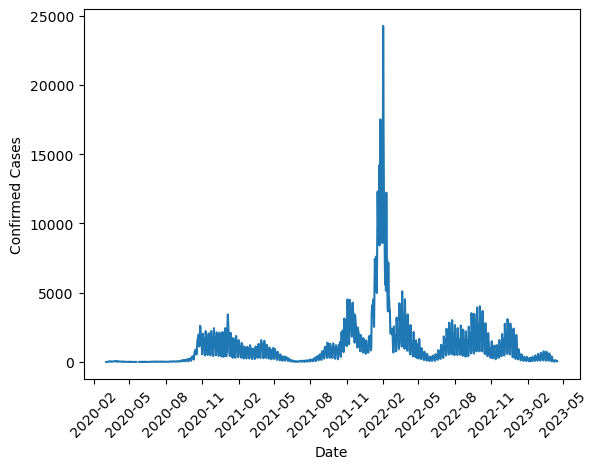

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

cases = pd.read_csv("podatki/cases.csv.txt")

cases['date'] = pd.to_datetime(cases['date'])


plt.plot(cases['date'], cases['cases.confirmed'])
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()



Kot vidimo je število dnevnih okužb s kovidom doseglo absoluten vrh nekje v začetku leta 2022. Najdimo datum.

In [11]:
max_cases_index = cases['cases.confirmed'].idxmax()
date_with_max_cases = cases.loc[max_cases_index, 'date']

print('The date with the most confirmed cases is:', date_with_max_cases)

The date with the most confirmed cases is: 2022-02-01 00:00:00


Ugotovili smo, da je do največ okužb prišlo 1. 2. 2022, to je natanko en dan po predvidenem koncu mesec prej uveljavljenega Protikoronskega paketa 10 (PKP10), ki je bil očitno neučinkovit. O vladnih odločitvah glede protikoronskih ukrepov bi lahko debatirali in nikoli prišli do dna, zato se te teme ne bova dotaknila. Zanimivo pa je, da je do viška okužb prišlo več kot leto dni po sprejetju cepiv. Zakaj je do tega prišlo? Smo Slovenci samo ignorantni proticepilci ali cepiva dejansko statistično ne zmanjšajo možnosti okužbe. Poglejmo si.

Total full vaccinations up to 2022-02-01: 1202033


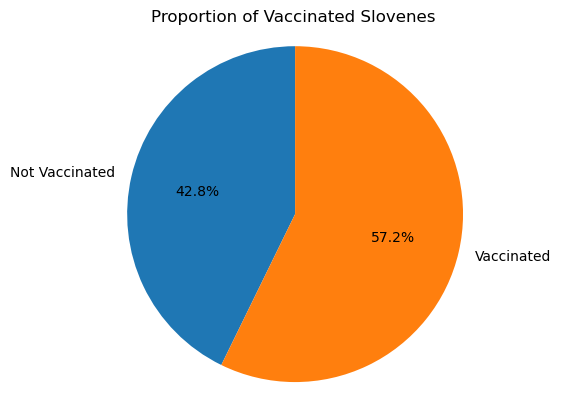

In [14]:
#Najdemo delež polno cepljenih ljudi na tisti dan

vaccined = pd.read_csv("podatki/precepljenost.csv")

vaccined['dt'] = pd.to_datetime(vaccined['dt'])

# Filter the DataFrame to only include rows up to and including 2022-02-01
vaccined_filtered = vaccined[vaccined['dt'] <= '2022-02-01']

# Sum columns 1 through 6 for the filtered DataFrame
total = vaccined_filtered.iloc[:, 1:7].sum().sum()

print('Total full vaccinations up to 2022-02-01:', total)

slovenes_count = 2100000

vacc_perc = total/slovenes_count

# Create a pie chart
labels = ['Not Vaccinated', 'Vaccinated']
sizes = [1-vacc_perc, vacc_perc]
colors = ['#1f77b4', '#ff7f0e']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title('Proportion of Vaccinated Slovenes')

plt.show()


Kot vidimo iz prelepega in profesorju ljubega tortnega diagrama, je bilo do 1. 2. 2022 precepljenih več kot milijon prebivalcev ali natančneje 57,2%, kar je slabše od večine držav zahodnega sveta in skoraj celotne Azije, ni pa zares porazno. Vprašanje ki sledi je: "Ali cepivo zares pomaga proti zbolevanju zaradi koronavirusa?".

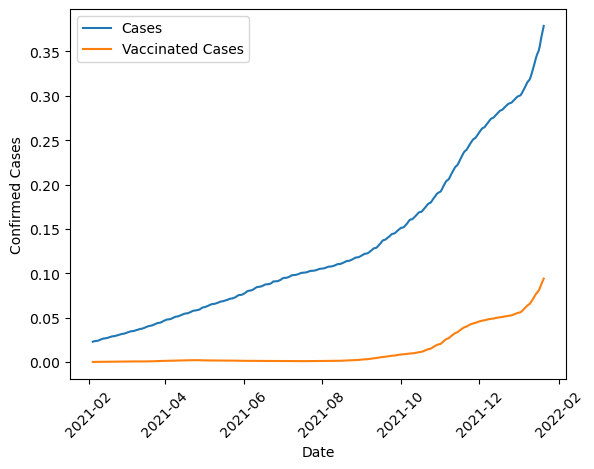

In [62]:
# Najprej iz podatkovne zbirke izločimo podatke dni pred prvim cepljenjem
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

cases = pd.read_csv("podatki/cases.csv.txt")
vaccinated = pd.read_csv("podatki/precepljenost.csv")

first_nonempty_index = ((vaccinated['st_polno_cepljeni_0_17'] > 0) |
                        (vaccinated['st_polno_cepljeni_18_24'] > 0) |
                        (vaccinated['st_polno_cepljeni_25_44'] > 0) |
                        (vaccinated['st_polno_cepljeni_45_64'] > 0) |
                        (vaccinated['st_polno_cepljeni_65_74'] > 0) |
                        (vaccinated['st_polno_cepljeni_75_plus'] > 0)).idxmax()

vaccinated = vaccinated.loc[first_nonempty_index:]

first_nonempty_date = vaccinated.loc[first_nonempty_index, 'dt']

cases = cases[cases['date'] >= first_nonempty_date]

remove_cases = cases.loc[cases.index[0], 'cases.confirmed.todate'] - cases.loc[cases.index[0], 'cases.confirmed']

cases['cases.confirmed.todate'] = cases['cases.confirmed.todate'] - remove_cases

cases['date'] = pd.to_datetime(cases['date'])

#sedaj imamo cases in vaccinated omejene, da se začnejo z dnem prvega cepljenja. sedaj moramo dobiti vaccinated.cases/all vaccinated in (cases-vaccinated.cases)/(all-vaccinated)
slovenes_count = 2100000

all_cases = cases[['date', 'cases.confirmed.todate', 'cases.vaccinated.confirmed.todate']].copy()

all_vacc = 0
for i, row in vaccinated.iterrows():
    current_sum = row['st_polno_cepljeni_0_17'] + row['st_polno_cepljeni_18_24'] + row['st_polno_cepljeni_25_44'] + row['st_polno_cepljeni_45_64'] + row['st_polno_cepljeni_65_74'] + row['st_polno_cepljeni_75_plus']
    all_vacc += current_sum
    all_unvacc = slovenes_count-all_vacc
    all_cases.loc[all_cases['date'] == row['dt'], 'cases.confirmed.todate'] = (all_cases.loc[all_cases['date'] == row['dt'], 'cases.confirmed.todate'] - all_cases.loc[all_cases['date'] == row['dt'], 'cases.vaccinated.confirmed.todate'])/ all_unvacc
    all_cases.loc[all_cases['date'] == row['dt'], 'cases.vaccinated.confirmed.todate'] = all_cases.loc[all_cases['date'] == row['dt'], 'cases.vaccinated.confirmed.todate'] / all_vacc




plt.plot(all_cases['date'], all_cases['cases.confirmed.todate'])
plt.plot(all_cases['date'], all_cases['cases.vaccinated.confirmed.todate'])
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend(['Cases', 'Vaccinated Cases'])

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()


Na grafu sva z oranžno črto prikazala razmerje vseh do sedaj okuženih in cepljenih proti vsem cepljenim ter z modro črto razmerje vseh do sedaj okuženih ki niso bili cepljeni proti vsem necepljenim. Vidimo da je okuženih cepljenih precej manj, zato bi lahko rekli, da cepljenje dela. Vendar pridemo do problema, da ob začetku najhujšega koronskega vala podatkov o obolelih in cepljenih niso več posodabljali, kar je precej vprašljivo. Na grafu vidimo, da funkcija začenja eksponentno rasti, o njenih nadaljnih stanjih pa lahko le spekuliramo.

Vlada je izvajala raznorazne protikoronske ukrepe, ki pa so različno vplivali na človekovo psihološko stanje. Poglejmo si nekaj zanimivih statistik

C:\Users\Luka\AppData\Local\Temp\ipykernel_29940\4215362639.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = samomori.mean(axis=1)


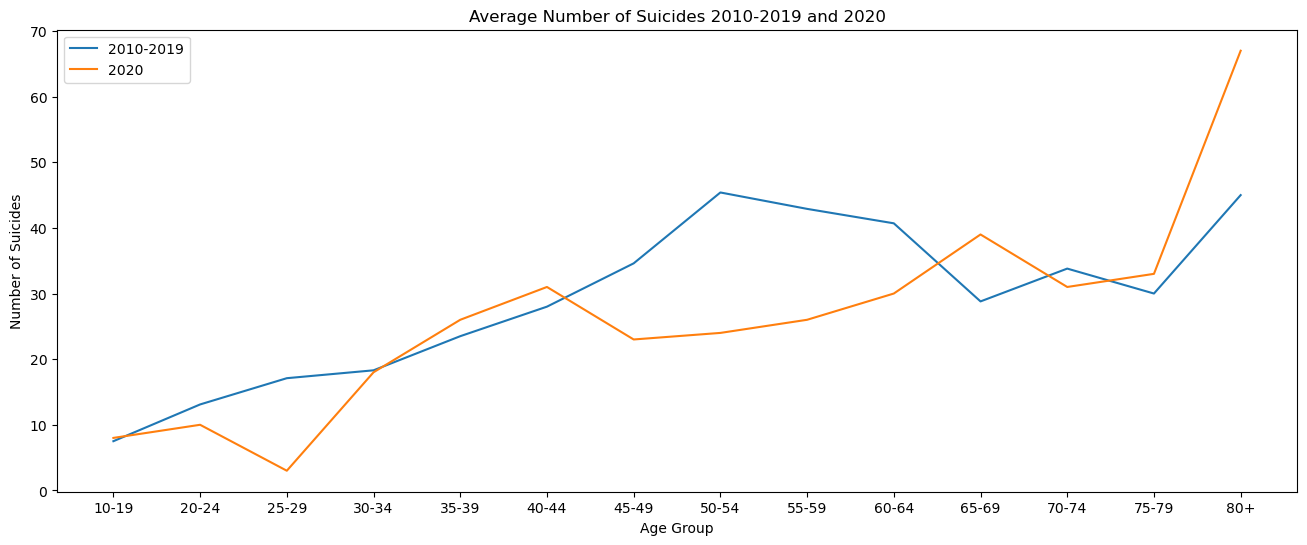

In [24]:
import matplotlib.pyplot as plt
import numpy as np

samomori = pd.read_csv("podatki/samomori.csv", delimiter=';')
sui2020 = samomori["2020 Samomori - SKUPAJ"].copy()
samomori = samomori.drop(samomori.columns[-1], axis=1)

averages = samomori.mean(axis=1)
xaxis = ['10-19', '20-24', '25-29', '30-34','35-39', '40-44','45-49', '50-54','55-59', '60-64', '65-69', '70-74', '75-79', '80+',]
x_values = np.arange(len(averages))

fig, ax = plt.subplots(figsize=(16, 6))

# Plot the values for averages
ax.plot(xaxis, averages, '-', label='2010-2019')

# Plot the values for sui2020
ax.plot(xaxis, sui2020, '-', label='2020')

# Set labels and title for the graph
ax.set_xlabel('Age Group')
ax.set_ylabel('Number of Suicides')
ax.set_title('Average Number of Suicides 2010-2019 and 2020')

# Add a legend
ax.legend()

# Show the plot
plt.show()


Vidimo, da se je samomorilnost pri srednjih letih leta 2020 zmanjšala, pri najstarejših pa močno povečala, le ti pa so že tako ali tako najbolj ogrožena skupina ljudi. Podatke za število samomorov imava samo do leta 2020, zato je težko sklepati, ali se je trend pri najstarejših nadaljeval ali ne.